# Photonic Quantum Convolutional Neural Network with Adaptive State Injection

In this notebook, we will implement the Photonic QCNN from [this paper](https://arxiv.org/abs/2504.20989) and display its usage on the binary 8x8 MNIST classification task of differentiating 0 and 1. All of this will be done using [MerLin](https://merlinquantum.ai), a photonic QML framework for the optimization of photonic circuits that was integrated with PyTorch for intuitive usage.

# 0. Imports

In [30]:
import matplotlib.pyplot as plt
import merlin
import numpy as np
import torch
import torch.nn.functional as F  # noqa: N812
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from torch import nn, optim
from tqdm import trange

Imports of our photonic QCNN constituents

In [13]:
from photonic_QCNN.src.qcnn import OneHotEncoder, QConv2d, QPooling, QDense, Measure, generate_all_fock_states

# 1. Data

Function to fetch the 8x8 MNIST dataset from sklearn and choose the selected labels.

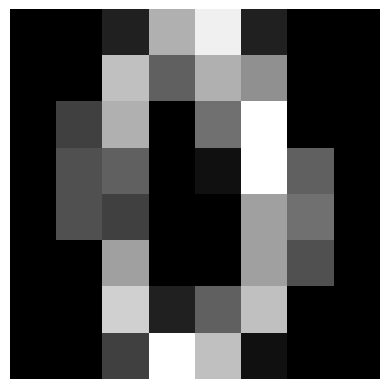

With label: 0


In [14]:
def get_mnist(random_state, class_list=(0, 1)):
    """
    Get MNIST dataset reduced to certain labels.

    :param random_state
    :param class_list: List of labels to keep

    :return: x_train, x_test, y_train, y_test
    """
    mnist_x, mnist_y = load_digits(return_X_y=True)

    # Keep only selected classes
    mask = np.isin(mnist_y, class_list)
    mnist_x = mnist_x[mask]
    mnist_y = mnist_y[mask]

    # Train/test split
    mnist_x_train, mnist_x_test, mnist_y_train, mnist_y_test = train_test_split(
        mnist_x, mnist_y, test_size=200, random_state=random_state
    )
    # Since there are only 360 data points in this specific dataset with labels = 0 or 1, that implies that we will have 160 training points.

    # Reshape to 8×8 images
    mnist_x_train = mnist_x_train.reshape(-1, 8, 8)
    mnist_x_test = mnist_x_test.reshape(-1, 8, 8)

    return mnist_x_train, mnist_x_test, mnist_y_train, mnist_y_test


# Visualize an image from our training data
x_train, x_test, y_train, y_test = get_mnist(42)
plt.imshow(x_train[0], cmap="gray")
plt.axis("off")  # hide axes
plt.show()
print(f"With label: {y_train[0]}")

Let us examine an example of the opposing class:

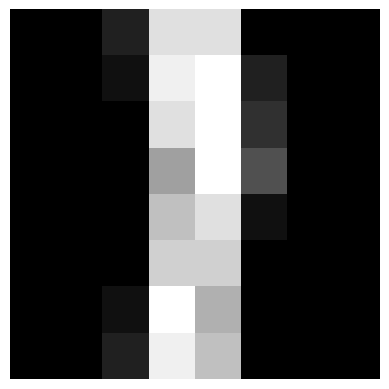

With label: 1


In [15]:
# Visualize an image from our training data
x_train, x_test, y_train, y_test = get_mnist(42)
plt.imshow(x_train[1], cmap="gray")
plt.axis("off")  # hide axes
plt.show()
print(f"With label: {y_train[1]}")

To convert the dataset arrays to data loaders.

In [16]:
def convert_dataset_to_tensor(x_train, x_test, y_train, y_test):
    x_train = torch.tensor(x_train, dtype=torch.float32)
    x_test = torch.tensor(x_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)
    return x_train, x_test, y_train, y_test


def convert_tensor_to_loader(x_train, y_train, batch_size=6):
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    return train_loader

# 2. Model

Here we define our complete Photonic QCNN model

In [21]:
class PQCNN(nn.Module):
    def __init__(
        self, dims, measure_subset, output_formatting, num_classes=2
    ):
        super().__init__()
        self.num_modes_end = dims[0]
        self.num_modes_measured = (
            measure_subset if measure_subset is not None else dims[0]
        )

        self.one_hot_encoding = OneHotEncoder()
        self.conv2d = QConv2d(dims, kernel_size=2, stride=2)
        self.pooling = QPooling(dims, kernel_size=2)
        self.dense = QDense((int(dims[0] / 2), int(dims[1] / 2)))
        self.measure = Measure(m=dims[0], n=2, subset=measure_subset)

        self.qcnn = nn.Sequential(
            self.one_hot_encoding, self.conv2d, self.pooling, self.dense, self.measure
        )

        # Output dimension of the QCNN
        states = list(generate_all_fock_states(self.num_modes_end, 2))
        qcnn_output_dim = len(states)
        self.qcnn_output_dim = qcnn_output_dim

        # Output mapping strategy
        if output_formatting == "Train_linear":
            self.output_mapping = nn.Linear(qcnn_output_dim, num_classes)
        elif output_formatting == "No_train_linear":
            self.output_mapping = nn.Linear(qcnn_output_dim, num_classes)
            self.output_mapping.weight.requires_grad = False
            self.output_mapping.bias.requires_grad = False
        elif output_formatting == "Lex_grouping":
            self.output_mapping = merlin.sampling.mappers.LexGroupingMapper(
                qcnn_output_dim, num_classes
            )
        elif output_formatting == "Mod_grouping":
            self.output_mapping = merlin.sampling.mappers.ModGroupingMapper(
                qcnn_output_dim, num_classes
            )
        else:
            raise NotImplementedError(f'Output formatting "{output_formatting}" not implemented.')

    def forward(self, x):
        probs = self.qcnn(x)
        output = self.output_mapping(probs)
        output = output * 66

        return output

# 3. Training

Train the PQCNN with the CrossEntropyLoss using Adam optimizer.

In [22]:
def train_model(model, train_loader, x_train, x_test, y_train, y_test):
    """Train a single model and return training history"""
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=0.001)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    loss_fn = nn.CrossEntropyLoss()

    loss_history = []
    train_acc_history = []
    test_acc_history = []

    # Initial accuracy
    with torch.no_grad():
        output_train = model(x_train)
        pred_train = torch.argmax(output_train, dim=1)
        train_acc = (pred_train == y_train).float().mean().item()

        output_test = model(x_test)
        pred_test = torch.argmax(output_test, dim=1)
        test_acc = (pred_test == y_test).float().mean().item()

        train_acc_history.append(train_acc)
        test_acc_history.append(test_acc)

    # Training loop
    for _epoch in trange(20, desc="Training epochs"):
        for _batch_idx, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(images)
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()
            loss_history.append(loss.item())

        # Evaluate accuracy
        with torch.no_grad():
            output_train = model(x_train)
            pred_train = torch.argmax(output_train, dim=1)
            train_acc = (pred_train == y_train).float().mean().item()

            output_test = model(x_test)
            pred_test = torch.argmax(output_test, dim=1)
            test_acc = (pred_test == y_test).float().mean().item()

            train_acc_history.append(train_acc)
            test_acc_history.append(test_acc)
        scheduler.step()
    return {
        "loss_history": loss_history,
        "train_acc_history": train_acc_history,
        "test_acc_history": test_acc_history,
        "final_train_acc": train_acc,
        "final_test_acc": test_acc,
    }

Set up hyperparameters.

In [23]:
# Hyperparameters
measure_subset = 2  # Number of modes to measure

output_formatting = "Mod_grouping"  # ['Train_linear', 'No_train_linear', 'Lex_grouping', 'Mod_grouping']
# Format of the mapping from circuit output to number of labels. The only one that has trainable parameters is 'Train_linear'.

random_states = [42, 123, 456, 789, 999]

Multiple runs:

In [24]:
all_results = {}

for i, random_state in enumerate(random_states):
    print(f"About to start experiment {i + 1}/5")
    x_train, x_test, y_train, y_test = get_mnist(random_state=random_state)
    x_train, x_test, y_train, y_test = convert_dataset_to_tensor(
        x_train, x_test, y_train, y_test
    )
    train_loader = convert_tensor_to_loader(x_train, y_train)
    dims = (8, 8)

    pqcnn = PQCNN(dims, measure_subset, output_formatting)
    num_params = sum(p.numel() for p in pqcnn.parameters() if p.requires_grad)
    print(f"Model has {num_params} trainable parameters")
    print(f"Output of circuit has size {pqcnn.qcnn_output_dim} (before output_formatting)")

    results = train_model(pqcnn, train_loader, x_train, x_test, y_train, y_test)
    print(
        f"MNIST - Final train: {results['final_train_acc']:.4f}, test: {results['final_test_acc']:.4f}"
    )
    print(f"Experiment {i + 1}/5 completed")
    all_results[f"run_{i}"] = results

About to start experiment 1/5
Model has 60 trainable parameters
Output of circuit has size 36


Training epochs: 100%|██████████| 20/20 [00:04<00:00,  4.18it/s]


MNIST - Final train: 1.0000, test: 0.9800
Experiment 1/5 completed
About to start experiment 2/5
Model has 60 trainable parameters
Output of circuit has size 36


Training epochs: 100%|██████████| 20/20 [00:04<00:00,  4.07it/s]


MNIST - Final train: 1.0000, test: 1.0000
Experiment 2/5 completed
About to start experiment 3/5
Model has 60 trainable parameters
Output of circuit has size 36


Training epochs: 100%|██████████| 20/20 [00:04<00:00,  4.20it/s]


MNIST - Final train: 1.0000, test: 0.9950
Experiment 3/5 completed
About to start experiment 4/5
Model has 60 trainable parameters
Output of circuit has size 36


Training epochs: 100%|██████████| 20/20 [00:04<00:00,  4.14it/s]


MNIST - Final train: 1.0000, test: 1.0000
Experiment 4/5 completed
About to start experiment 5/5
Model has 60 trainable parameters
Output of circuit has size 36


Training epochs: 100%|██████████| 20/20 [00:04<00:00,  4.13it/s]

MNIST - Final train: 0.9937, test: 0.9900
Experiment 5/5 completed


# 4. Results

Display training metrics and print overall results

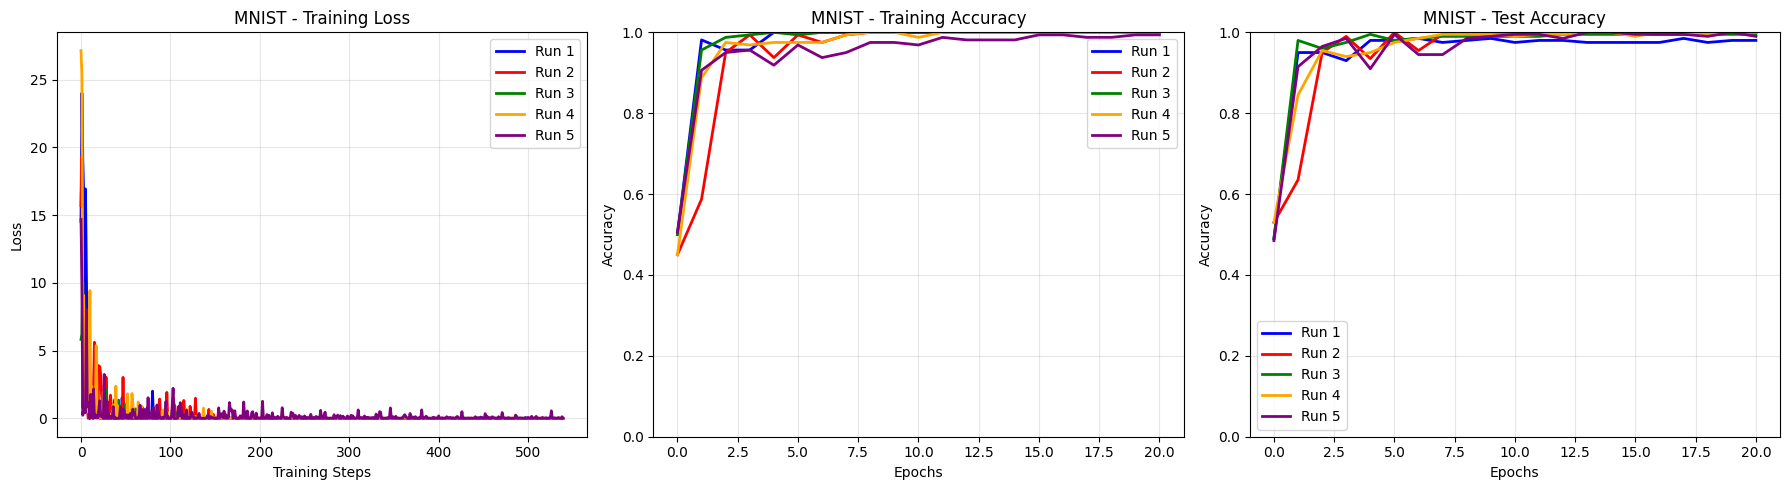


Summary Results:
Binary MNIST 0 vs 1:
  Train Accuracy: 0.999 ± 0.003
  Test Accuracy:  0.993 ± 0.007


In [25]:
# Save summary statistics
summary = {}
num_runs = len(all_results)
train_accs = [all_results[f"run_{i}"]["final_train_acc"] for i in range(num_runs)]
test_accs = [all_results[f"run_{i}"]["final_test_acc"] for i in range(num_runs)]

summary = {
    "train_acc_mean": np.mean(train_accs),
    "train_acc_std": np.std(train_accs),
    "test_acc_mean": np.mean(test_accs),
    "test_acc_std": np.std(test_accs),
    "train_accs": train_accs,
    "test_accs": test_accs,
}

# Create training plots for each dataset
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ["blue", "red", "green", "orange", "purple"]

# Plot loss history for this dataset
ax_loss = axes[0]
for run_idx in range(num_runs):
    loss_history = all_results[f"run_{run_idx}"]["loss_history"]
    ax_loss.plot(
        loss_history,
        color=colors[run_idx],
        alpha=1,
        linewidth=2,
        label=f"Run {run_idx + 1}",
    )
ax_loss.set_title("MNIST - Training Loss")
ax_loss.set_xlabel("Training Steps")
ax_loss.set_ylabel("Loss")
ax_loss.legend()
ax_loss.grid(True, alpha=0.3)

# Plot train accuracy for this dataset
ax_train = axes[1]
for run_idx in range(num_runs):
    train_acc_history = all_results[f"run_{run_idx}"]["train_acc_history"]
    epochs = range(len(train_acc_history))
    ax_train.plot(
        epochs,
        train_acc_history,
        color=colors[run_idx],
        alpha=1,
        linewidth=2,
        label=f"Run {run_idx + 1}",
    )
ax_train.set_title("MNIST - Training Accuracy")
ax_train.set_xlabel("Epochs")
ax_train.set_ylabel("Accuracy")
ax_train.legend()
ax_train.grid(True, alpha=0.3)
ax_train.set_ylim(0, 1)

# Plot test accuracy for this dataset
ax_test = axes[2]
for run_idx in range(num_runs):
    test_acc_history = all_results[f"run_{run_idx}"]["test_acc_history"]
    epochs = range(len(test_acc_history))
    ax_test.plot(
        epochs,
        test_acc_history,
        color=colors[run_idx],
        alpha=1,
        linewidth=2,
        label=f"Run {run_idx + 1}",
    )
ax_test.set_title("MNIST - Test Accuracy")
ax_test.set_xlabel("Epochs")
ax_test.set_ylabel("Accuracy")
ax_test.legend()
ax_test.grid(True, alpha=0.3)
ax_test.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Print summary
print("\nSummary Results:")
print("=" * 50)
print("Binary MNIST 0 vs 1:")
print(
    f"  Train Accuracy: {summary['train_acc_mean']:.3f} ± {summary['train_acc_std']:.3f}"
)
print(
    f"  Test Accuracy:  {summary['test_acc_mean']:.3f} ± {summary['test_acc_std']:.3f}"
)

As we can see, our PQCNN easily and consistently manages to classify 8x8 MNIST images between labels 0 and 1.

# 5. Classical comparison

Let us now compare these results with the ones from a classical CNN of comparable number of parameters. We first need to define this CNN:

In [26]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv layer: in_channels=1 (grayscale), out_channels=1, kernel=3
        self.conv1 = nn.Conv2d(1, 2, kernel_size=3)  # 1*2*3*3 + 2 bias = 20 params
        # output of size (6, 6, 2)

        self.pool = nn.MaxPool2d(2, 2)
        # output of size (3, 3, 2)

        # Fully connected: after conv + pool, output size is 2 × 3 × 3 = 18
        self.fc1 = nn.Linear(18, 2)  # 18*2 + 2 biases = 38 params → we'll adjust

        # Total number of params: 58

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)  # Flatten except batch dim
        x = self.fc1(x)
        return x

Let us redefine the training function:

In [27]:
def train_model(model, train_loader, x_train, x_test, y_train, y_test):
    """Train a single model and return training history"""
    optimizer = torch.optim.Adam(
        model.parameters(), lr=0.1, weight_decay=0.001, betas=(0.7, 0.9)
    )
    # scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    loss_fn = nn.CrossEntropyLoss()

    loss_history = []
    train_acc_history = []
    test_acc_history = []

    # Initial accuracy
    with torch.no_grad():
        output_train = model(x_train)
        pred_train = torch.argmax(output_train, dim=1)
        train_acc = (pred_train == y_train).float().mean().item()

        output_test = model(x_test)
        pred_test = torch.argmax(output_test, dim=1)
        test_acc = (pred_test == y_test).float().mean().item()

        train_acc_history.append(train_acc)
        test_acc_history.append(test_acc)

    # Training loop
    for _epoch in trange(100, desc="Training epochs"):
        for _batch_idx, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(images)
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()
            loss_history.append(loss.item())

        # Evaluate accuracy
        with torch.no_grad():
            output_train = model(x_train)
            pred_train = torch.argmax(output_train, dim=1)
            train_acc = (pred_train == y_train).float().mean().item()

            output_test = model(x_test)
            pred_test = torch.argmax(output_test, dim=1)
            test_acc = (pred_test == y_test).float().mean().item()

            train_acc_history.append(train_acc)
            test_acc_history.append(test_acc)
        # scheduler.step()
    return {
        "loss_history": loss_history,
        "train_acc_history": train_acc_history,
        "test_acc_history": test_acc_history,
        "final_train_acc": train_acc,
        "final_test_acc": test_acc,
    }

Then we run the experiments:

In [28]:
all_results = {}

for i, random_state in enumerate(random_states):
    print(f"About to start experiment {i + 1}/5")
    x_train, x_test, y_train, y_test = get_mnist(random_state=random_state)
    x_train, x_test, y_train, y_test = convert_dataset_to_tensor(
        x_train, x_test, y_train, y_test
    )
    x_train = x_train.unsqueeze(dim=1)
    x_test = x_test.unsqueeze(dim=1)
    train_loader = convert_tensor_to_loader(x_train, y_train)
    dims = (8, 8)

    classical_cnn = SmallCNN()
    num_params = sum(p.numel() for p in classical_cnn.parameters() if p.requires_grad)
    print(f"Model has {num_params} trainable parameters")

    results = train_model(classical_cnn, train_loader, x_train, x_test, y_train, y_test)
    print(
        f"MNIST - Final train: {results['final_train_acc']:.4f}, test: {results['final_test_acc']:.4f}"
    )
    print(f"Experiment {i + 1}/5 completed")
    all_results[f"run_{i}"] = results

About to start experiment 1/5
Model has 58 trainable parameters


Training epochs: 100%|██████████| 100/100 [00:00<00:00, 153.01it/s]


MNIST - Final train: 0.9875, test: 0.9800
Experiment 1/5 completed
About to start experiment 2/5
Model has 58 trainable parameters


Training epochs: 100%|██████████| 100/100 [00:00<00:00, 152.62it/s]


MNIST - Final train: 0.9937, test: 0.9950
Experiment 2/5 completed
About to start experiment 3/5
Model has 58 trainable parameters


Training epochs: 100%|██████████| 100/100 [00:00<00:00, 163.67it/s]


MNIST - Final train: 1.0000, test: 0.9750
Experiment 3/5 completed
About to start experiment 4/5
Model has 58 trainable parameters


Training epochs: 100%|██████████| 100/100 [00:00<00:00, 163.94it/s]


MNIST - Final train: 1.0000, test: 1.0000
Experiment 4/5 completed
About to start experiment 5/5
Model has 58 trainable parameters


Training epochs: 100%|██████████| 100/100 [00:00<00:00, 164.11it/s]

MNIST - Final train: 1.0000, test: 0.9850
Experiment 5/5 completed


Visualize the results

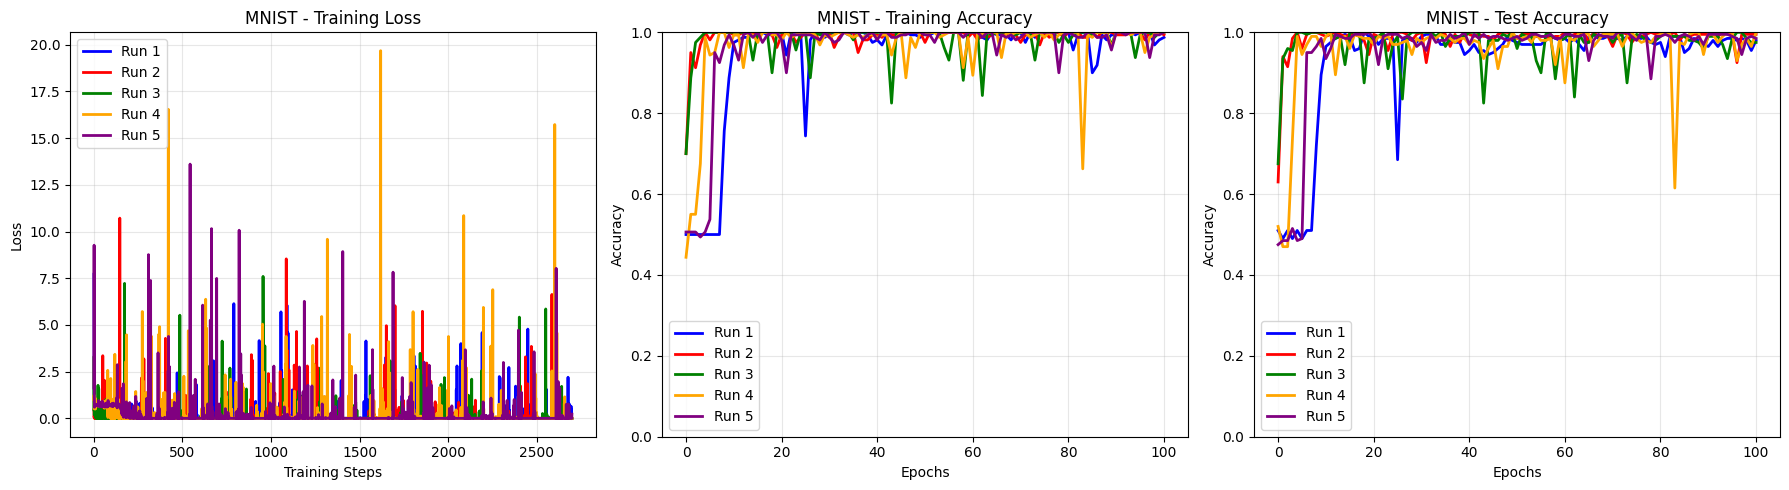


Summary Results:
Binary MNIST 0 vs 1:
  Train Accuracy: 0.996 ± 0.005
  Test Accuracy:  0.987 ± 0.009


In [29]:
# Save summary statistics
summary = {}
num_runs = len(all_results)
train_accs = [all_results[f"run_{i}"]["final_train_acc"] for i in range(num_runs)]
test_accs = [all_results[f"run_{i}"]["final_test_acc"] for i in range(num_runs)]

summary = {
    "train_acc_mean": np.mean(train_accs),
    "train_acc_std": np.std(train_accs),
    "test_acc_mean": np.mean(test_accs),
    "test_acc_std": np.std(test_accs),
    "train_accs": train_accs,
    "test_accs": test_accs,
}

# Create training plots for each dataset
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ["blue", "red", "green", "orange", "purple"]

# Plot loss history for this dataset
ax_loss = axes[0]
for run_idx in range(num_runs):
    loss_history = all_results[f"run_{run_idx}"]["loss_history"]
    ax_loss.plot(
        loss_history,
        color=colors[run_idx],
        alpha=1,
        linewidth=2,
        label=f"Run {run_idx + 1}",
    )
ax_loss.set_title("MNIST - Training Loss")
ax_loss.set_xlabel("Training Steps")
ax_loss.set_ylabel("Loss")
ax_loss.legend()
ax_loss.grid(True, alpha=0.3)

# Plot train accuracy for this dataset
ax_train = axes[1]
for run_idx in range(num_runs):
    train_acc_history = all_results[f"run_{run_idx}"]["train_acc_history"]
    epochs = range(len(train_acc_history))
    ax_train.plot(
        epochs,
        train_acc_history,
        color=colors[run_idx],
        alpha=1,
        linewidth=2,
        label=f"Run {run_idx + 1}",
    )
ax_train.set_title("MNIST - Training Accuracy")
ax_train.set_xlabel("Epochs")
ax_train.set_ylabel("Accuracy")
ax_train.legend()
ax_train.grid(True, alpha=0.3)
ax_train.set_ylim(0, 1)

# Plot test accuracy for this dataset
ax_test = axes[2]
for run_idx in range(num_runs):
    test_acc_history = all_results[f"run_{run_idx}"]["test_acc_history"]
    epochs = range(len(test_acc_history))
    ax_test.plot(
        epochs,
        test_acc_history,
        color=colors[run_idx],
        alpha=1,
        linewidth=2,
        label=f"Run {run_idx + 1}",
    )
ax_test.set_title("MNIST - Test Accuracy")
ax_test.set_xlabel("Epochs")
ax_test.set_ylabel("Accuracy")
ax_test.legend()
ax_test.grid(True, alpha=0.3)
ax_test.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Print summary
print("\nSummary Results:")
print("=" * 50)
print("Binary MNIST 0 vs 1:")
print(
    f"  Train Accuracy: {summary['train_acc_mean']:.3f} ± {summary['train_acc_std']:.3f}"
)
print(
    f"  Test Accuracy:  {summary['test_acc_mean']:.3f} ± {summary['test_acc_std']:.3f}"
)

With 58 parameters classically (versus the 60 quantum parameters), we end up with an equivalent performance in terms of accuracy. The non-smoothness of the classical training differentiates the two but more hyperparameters optimization could solve this issue.